In [1]:
# Import all the necessary libraries
import sys
if 'src' not in sys.path:
    sys.path.append('src')
import os
import warnings
warnings.filterwarnings("ignore")
    
import numpy as np
import pandas as pd
from scipy.stats import kendalltau,spearmanr,pearsonr,gaussian_kde

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.patches import Polygon

import pyBigWig
from tqdm import tqdm

np.random.seed(42)

In [2]:
# Cell line of interest
cell_line = "hepg2"
seeds = [1337, 2714, 5040, 5452, 5895, 5994, 6286, 8737, 9354, 9597]

pred_dim = 200

variance_list = []
predictions_list = []
for i, seed in enumerate(seeds):
    results = np.load(f'../results/{cell_line}/paper-hg38-map-concat-stage1024-rf-lrelu-eval-stg-newsplit-newdata-atac-var-beta-neg-s{seed}/results.npz')
    if i == 0:
        targets = np.reshape(results['targets'], [-1, pred_dim])
    predictions_seed = np.reshape(results['predictions'], [-1, pred_dim])
    variance_seed = np.reshape(results['variance'], [-1, pred_dim])
    variance_list.append(variance_seed)
    predictions_list.append(predictions_seed)
aleatoric_uncertainty = np.mean(variance_list, axis=0)
predictions = np.mean(predictions_list, axis=0)
predictions_std = np.std(predictions_list, axis=0, ddof=1)
epistemic_uncertainty = predictions_std**2
variance = aleatoric_uncertainty + epistemic_uncertainty
predictions = np.clip(predictions, 0, None)

res = 5000
chr_data = np.reshape(results['chr'], [-1, pred_dim])
pos1 = np.reshape(results['pos1'], [-1, pred_dim])//res
pos2 = np.reshape(results['pos2'], [-1, pred_dim])//res
print(targets.shape, predictions.shape, chr_data.shape, pos1.shape, pos2.shape)

(35088, 200) (35088, 200) (35088, 200) (35088, 200) (35088, 200)


In [3]:
# Create result dataframe
result_df = pd.DataFrame({
    'chrom': chr_data.flatten(),
    'bin1': pos1.flatten(),
    'bin2': pos2.flatten(),
    'target': targets.flatten(),
    'preds': predictions.flatten(),
    'variance': variance.flatten(),
})
result_df['dist'] = abs(result_df['bin2']-result_df['bin1'])
result_df = result_df[result_df.dist < 203]

In [4]:
# Remove unmappable regions
unmap = pd.read_csv("../data/blacklist/basenji_unmappable.bed", sep="\t", names=["chr", "start", "end"])
test_chr = [*result_df.chrom.unique()]
test_chr = [f'chr{str(int(chr))}' for chr in test_chr]
unmap = unmap[unmap.chr.isin(test_chr)]
drop_info = {}
for chr in test_chr:
    unmap_chr = unmap[unmap.chr == chr]
    chr = int(chr.split("chr")[-1])
    drop_list = []
    for _,row in tqdm(unmap_chr.iterrows()):
        start = row['start']
        end = row['end']
        skip_regions = []
        i = start
        while i<end:
            skip_regions.append(i//5000)
            i+=5000
        drop_list.extend(skip_regions)
    drop_info[chr] = drop_list

final_df = []
for chr, drop_list in drop_info.items():
    df_filter = result_df[result_df.chrom==chr]
    df_filter = df_filter[~df_filter.bin1.isin(drop_list)]
    df_filter = df_filter[~df_filter.bin2.isin(drop_list)]
    final_df.append(df_filter)
final_df = pd.concat(final_df, ignore_index=True)
final_df.head()

46535it [00:01, 42484.60it/s]
114616it [00:02, 42583.48it/s]
78231it [00:01, 40242.12it/s]


,chrom,bin1,bin2,target,preds,variance,dist
0,19.0,213.0,234.0,4.192472,3.529265,0.560430,21.0
1,19.0,213.0,234.0,4.192472,3.539342,0.532250,21.0
2,19.0,213.0,234.0,4.192472,3.526241,0.551288,21.0
3,19.0,213.0,234.0,4.192472,3.522149,0.567110,21.0
4,19.0,213.0,234.0,4.192472,3.540891,0.514224,21.0


In [5]:
# Remove general blacklisted regions
blacklist = pd.read_csv("../data/blacklist/basenji_blacklist.bed", sep="\t", names=["chr", "start", "end"])
blacklist = blacklist[blacklist.chr.isin(test_chr)]
drop_info = {}
for chr in test_chr:
    blacklist_chr = blacklist[blacklist.chr == chr]
    chr = int(chr.split("chr")[-1])
    drop_list = []
    for _,row in tqdm(blacklist_chr.iterrows()):
        start = row['start']
        end = row['end']
        skip_regions = []
        i = start
        while i<=end:
            skip_regions.append(i//5000)
            i+=5000
        drop_list.extend(skip_regions)
    drop_info[chr] = drop_list

df_list = []
for chr, drop_list in drop_info.items():
    df_filter = final_df[final_df.chrom==chr]
    df_filter = df_filter[~df_filter.bin1.isin(drop_list)]
    df_filter = df_filter[~df_filter.bin2.isin(drop_list)]
    df_list.append(df_filter)
final_df = pd.concat(df_list, ignore_index=True)
final_df.head()

869it [00:00, 38062.35it/s]
183it [00:00, 41400.09it/s]
73it [00:00, 37587.06it/s]


,chrom,bin1,bin2,target,preds,variance,dist
0,19.0,213.0,234.0,4.192472,3.529265,0.560430,21.0
1,19.0,213.0,234.0,4.192472,3.539342,0.532250,21.0
2,19.0,213.0,234.0,4.192472,3.526241,0.551288,21.0
3,19.0,213.0,234.0,4.192472,3.522149,0.567110,21.0
4,19.0,213.0,234.0,4.192472,3.540891,0.514224,21.0


In [6]:
# Remove cell-type-specific blacklisted regions
blacklist = pd.read_csv(f"../data/blacklist/{cell_line.lower()}_blacklist.bed", sep="\t", names=["chr", "start", "end"])
blacklist = blacklist[blacklist.chr.isin(test_chr)]
drop_info = {}
for chr in test_chr:
    blacklist_chr = blacklist[blacklist.chr == chr]
    chr = int(chr.split("chr")[-1])
    blacklist_chr['bin1'] = blacklist_chr.start//5000
    
    drop_list = []
    for _,row in tqdm(blacklist_chr.iterrows()):
        start = row['bin1']
        skip_regions = [start, start+1, start-1]
        drop_list.extend(skip_regions)
    
    drop_info[chr] = drop_list

df_list = []
for chr, drop_list in drop_info.items():
    df_filter = final_df[final_df.chrom==chr]
    df_filter = df_filter[~df_filter.bin1.isin(drop_list)]
    df_filter = df_filter[~df_filter.bin2.isin(drop_list)]
    df_list.append(df_filter)
final_df = pd.concat(df_list, ignore_index=True)
final_df.head()

316it [00:00, 45476.07it/s]
2551it [00:00, 47454.33it/s]
1369it [00:00, 47832.08it/s]


,chrom,bin1,bin2,target,preds,variance,dist
0,19.0,213.0,234.0,4.192472,3.529265,0.560430,21.0
1,19.0,213.0,234.0,4.192472,3.539342,0.532250,21.0
2,19.0,213.0,234.0,4.192472,3.526241,0.551288,21.0
3,19.0,213.0,234.0,4.192472,3.522149,0.567110,21.0
4,19.0,213.0,234.0,4.192472,3.540891,0.514224,21.0


In [7]:
# Chromosome-wise correlation
for chr in test_chr:
    chr = int(chr.split("chr")[-1])
    df_chr = final_df[final_df.chrom == chr] 
    
    p1 = pearsonr(df_chr['preds'].values, df_chr['target'])[0]
    s1 = spearmanr(df_chr['preds'].values, df_chr['target'])[0]
    t1 = kendalltau(df_chr['preds'].values, df_chr['target'])[0]
    print("UniversalEPI")
    print(f"{cell_line}({chr}): \t R: {np.round(p1,3)}; Rho: {np.round(s1,3)}; Tau: {np.round(t1,3)}")

UniversalEPI
hepg2(19): 	 R: 0.956; Rho: 0.94; Tau: 0.794
UniversalEPI
hepg2(2): 	 R: 0.948; Rho: 0.933; Tau: 0.788
UniversalEPI
hepg2(6): 	 R: 0.959; Rho: 0.945; Tau: 0.801


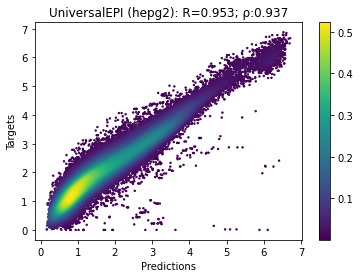

In [8]:
# Scatter plot on test data
t_b = np.array(final_df['target'].values.tolist())
t_hat_b = np.array(final_df['preds'].values.tolist())
r = np.round(pearsonr(t_b, t_hat_b)[0],3)
rho = np.round(spearmanr(t_b, t_hat_b)[0],3)
idx_subset = np.random.choice(np.arange(len(t_b)), size=50000, replace=False)
t_b_subset = t_b[idx_subset]
t_hat_b_subset = t_hat_b[idx_subset]
xy = np.vstack([t_hat_b_subset, t_b_subset])
z = gaussian_kde(xy)(xy)
idx = z.argsort()
t_hat_b_subset, t_b_subset, z = t_hat_b_subset[idx], t_b_subset[idx], z[idx]
plt.scatter(t_hat_b_subset, t_b_subset, c=z, s=2)
plt.title(f"UniversalEPI ({cell_line}): R={r}; ρ:{rho}")
plt.xlabel("Predictions")
plt.ylabel("Targets")
plt.colorbar()
plt.show()    

Text(0.5, 0.98, 'Distance Stratified Correlation')

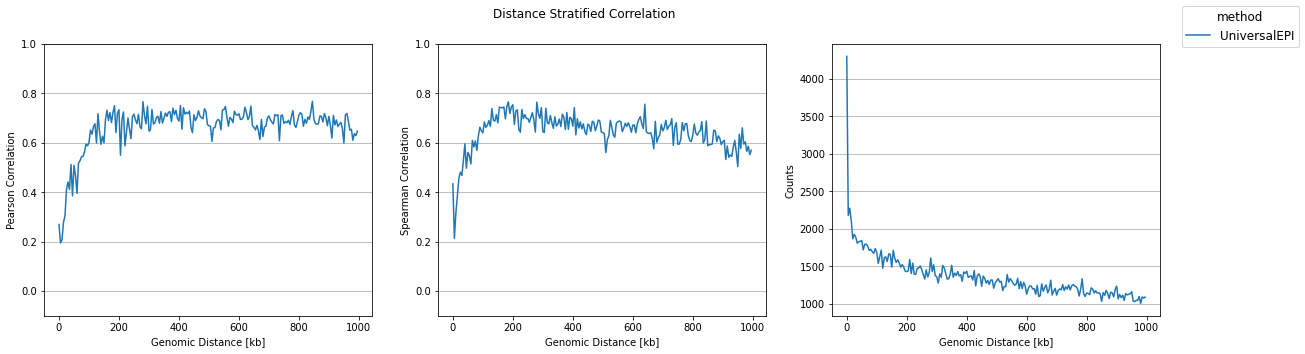

In [9]:
# Distance stratified correlation
r_d_200 = []
rho_d_200 = []
n_samples = []

for index in range(np.uint(1000000/res)):
    t_b_i = np.array(final_df[final_df.dist == index]['target'].values.tolist())
    t_hat_b_i = np.array(final_df[final_df.dist == index]['preds'].values.tolist())

    n_samples.append(len(np.array(t_b_i).flatten()))
    
    r_d_200.append(pearsonr(np.array(t_b_i).flatten(), np.array(t_hat_b_i).flatten())[0])
    rho, _ = spearmanr(np.array(t_b_i).flatten(), np.array(t_hat_b_i).flatten())
    rho_d_200.append(rho)

x_label = np.arange(0,len(r_d_200)) * res / 1000

f, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
ax[0].plot(x_label, np.array(r_d_200), label="UniversalEPI")
ax[0].grid(axis='y')
ax[0].set_ylim(-0.1,1)
ax[0].set_xlabel("Genomic Distance [kb]")
ax[0].set_ylabel("Pearson Correlation")

ax[1].plot(x_label, np.array(rho_d_200), label="UniversalEPI")
ax[1].grid(axis='y')
ax[1].set_ylim(-0.1,1)
ax[1].set_xlabel("Genomic Distance [kb]")
ax[1].set_ylabel("Spearman Correlation")

ax[2].plot(x_label, np.array(n_samples), label="UniversalEPI")
ax[2].grid(axis='y')
ax[2].set_xlabel("Genomic Distance [kb]")
ax[2].set_ylabel("Counts")

lines, labels = ax[1].get_legend_handles_labels()
f.legend(lines, labels, loc="upper right", title="method", fontsize='large', title_fontsize='large')
f.suptitle("Distance Stratified Correlation")

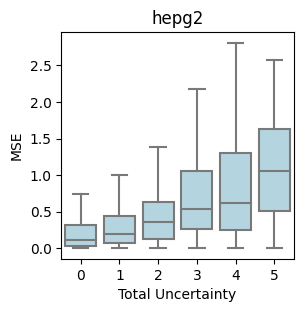

In [10]:
# Histogram of MSE stratified by uncertainty
import seaborn as sns
final_df['mse'] = (final_df['target']-final_df['preds'])**2
final_df = final_df[final_df['mse'] < 30]
bins = [0, 1, 2, 3, 4, 5]
bin_labels = ['0', '1', '2', '3', '4']
final_df['binned_var'] = pd.cut(final_df['variance'], bins=bins, labels=bin_labels, include_lowest=True)
final_df['binned_var'] = final_df['binned_var'].astype(str)
final_df['binned_var'] = final_df['binned_var'].replace('nan', '5')
plt.figure(figsize=(3, 3), dpi=100)
sns.boxplot(data=final_df, x='binned_var', y='mse', color='lightblue', showfliers=False)
plt.xlabel('Total Uncertainty')
plt.ylabel('MSE')
plt.title(f"{cell_line}")
plt.show()

In [11]:
# Get gene annotations
def process_gencode():
    gene_df = pd.read_csv("../data/genome/gencode.v47.annotation.gtf", sep="\t", comment="#", 
                            names=["chr", "source", "feature", "start", "end", "score", "strand", "frame", "attributes"])
    gene_df = gene_df[gene_df.feature == "gene"]
    gene_df["gene_name"] = gene_df.attributes.str.extract(r'gene_name "(.+?)";')
    gene_df['gene_type'] = gene_df.attributes.str.extract(r'gene_type "(.+?)";')
    gene_df = gene_df[gene_df.gene_type == "protein_coding"]
    gene_df = gene_df[['chr', 'start', 'end', 'gene_name', 'strand']]
    gene_df["tss"] = gene_df.apply(lambda x: x["start"] if x["strand"] == "+" else x["end"], axis=1)
    gene_df = gene_df.drop_duplicates(subset="gene_name")
    gene_df = gene_df.dropna()
    gene_df.to_csv("../data/genome/gencode_processed.csv", index=False)
    return gene_df

if os.path.isfile("../data/genome/gencode_processed.csv"):
    gene_df = pd.read_csv("../data/genome/gencode_processed.csv")
else:
    gene_df = process_gencode()
gene_df

,chr,start,end,gene_name,strand,tss
2486,chr1,65419,71585,OR4F5,+,65419
6557,chr1,450740,451678,OR4F29,-,451678
7172,chr1,685716,686654,OR4F16,-,686654
8430,chr1,923923,944575,SAMD11,+,923923
8735,chr1,944203,959309,NOC2L,-,959309
...,...,...,...,...,...,...
4105439,chrM,10470,10766,MT-ND4L,+,10470
4105446,chrM,10760,12137,MT-ND4,+,10760
4105460,chrM,12337,14148,MT-ND5,+,12337
4105466,chrM,14149,14673,MT-ND6,-,14673


In [ ]:
# Plot arcs for a given region
def plot_arcs(region, cutoff=1, zscore=False, gene_df=gene_df, result_df=result_df):
    
    chr, start, end = int((region.split(":")[0]).split('chr')[-1]), \
        int(region.split(":")[1].split("-")[0]), int(region.split(":")[1].split("-")[1])
    bin_start = start//res
    bin_end = end//res
    df_region = result_df[(result_df.chrom == chr) & (result_df.bin1 >= bin_start) & (result_df.bin2 <= bin_end)]
    df_region['pos1'] = df_region['bin1']*res
    df_region['pos2'] = df_region['bin2']*res
    if zscore:
        for chr in df_region.chrom.unique():
            df_chr = df_region[df_region.chrom == chr]
            df_chr['dist'] = abs(df_chr['pos2'] - df_chr['pos1'])
            for dist in df_chr.dist.unique():
                df_dist = df_chr[df_chr.dist == dist]
                df_chr.loc[df_chr.dist == dist, 'preds'] = (df_dist['preds'] - df_dist['preds'].mean())/df_dist['preds'].std()
        df_region['preds'] = df_chr['preds']
    else:
        df_region['preds'] = np.exp(df_region['preds'])-1
        df_region = df_region.groupby(['chrom','pos1', 'pos2']).agg({'preds':'sum'}).reset_index()
        df_region['preds'] = np.log1p(df_region['preds'])

    # Normalize preds values for shading
    norm = mcolors.Normalize(vmin=df_region["preds"].min(), vmax=df_region["preds"].max())    
    if zscore:
        cmap = cm.RdBu
    else:
        cmap = cm.Purples

    # Define genomic range
    chrom = "chr"+str(int(df_region["chrom"].iloc[0]))

    # Load ATAC-seq bigWig
    bw = pyBigWig.open(f"../data/atac/raw/{cell_line.upper()}_normalized.bw") 
    positions = np.arange(start, end, 100, dtype=int)  # Sample every 100bp
    atac_signal = np.array([bw.values(chrom, pos, pos + 100) for pos in positions])
    atac_signal = np.nan_to_num(atac_signal)  # Replace NaNs with zeros
    bw.close()

    atac_signal = atac_signal.max(axis=1)

    # Normalize genomic positions for plotting
    positions_kb = positions / 1000

    # Create figure with two subplots
    fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharex=True, gridspec_kw={"height_ratios": [3, 1, 0.5]}, dpi=100)

    # Plot 1: Hi-C Arcs
    axs[0].hlines(y=0, xmin=start/1000, xmax=end/1000, color='black', linewidth=1)
    if cutoff is not None:
        df_region = df_region[df_region.preds > cutoff]
    for _, row in df_region.iterrows():
        x1, x2 = row["pos1"] / 1000, row["pos2"] / 1000
        arc_height = (x2 - x1) / 2  
        arc = np.linspace(0, np.pi, 100)
        arc_x = np.linspace(x1, x2, 100)
        arc_y = np.sin(arc) * arc_height
        color = cmap(norm(row["preds"]))
        axs[0].plot(arc_x, arc_y, color=color, alpha=0.9)
    axs[0].set_title("{}: {:,}—{:,}".format(chrom, start, end))
    axs[0].set_ylabel("Predicted Interactions")
    axs[0].set_yticks([])
    axs[0].spines["top"].set_visible(False)
    axs[0].spines["right"].set_visible(False)
    axs[0].spines["bottom"].set_visible(False)
    axs[0].spines["left"].set_visible(False)

    # Plot 2: ATAC-seq Signal
    axs[1].fill_between(positions_kb, atac_signal, color="#FFC107", alpha=0.7)
    axs[1].set_ylabel("ATAC-seq")
    axs[1].set_xlim(start / 1000, end / 1000)  # Keep X-axis consistent
    axs[1].spines["top"].set_visible(False)
    axs[1].spines["right"].set_visible(False)
    axs[1].spines["bottom"].set_visible(False)

    # Plot 3: Gene Annotations
    gene_df = gene_df[gene_df.chr == chrom]
    gene_df = gene_df[(gene_df.end >= start) & (gene_df.start <= end)]
    for i, row in gene_df.iterrows():
        y_pos = (i+1) % 2 * 0.3  # Alternates between 0 and 0.3 to stagger labels
        j=0.25
        axs[2].hlines(y=j+y_pos, xmin=row["start"] / 1000, xmax=row["end"] / 1000, color="black", linewidth=3)
        if row['tss'] < start or row['tss'] > end:
            pass
        else:
            axs[2].text(row['tss']/1000, j-0.15-y_pos, row["gene_name"], ha="center", va="top", fontsize=8)
        tss_kb = row["tss"] / 1000
        if row["strand"] == '+':  
            triangle_coords = [(tss_kb, j+y_pos), (tss_kb, j+y_pos + 0.4), (tss_kb + 0.3, j+y_pos)]  # Right-facing
        else:
            triangle_coords = [(tss_kb, j+y_pos), (tss_kb, j+y_pos + 0.4), (tss_kb - 0.3, j+y_pos)]  # Left-facing

        # Add triangle to plot
        triangle = Polygon(triangle_coords, closed=True, facecolor="black", edgecolor="black")
        axs[2].add_patch(triangle)

    axs[2].set_yticks([])
    axs[2].set_xlabel("Genomic Position (Kb)")
    axs[2].set_xlim(start / 1000, end / 1000)  # Keep X-axis consistent
    axs[2].set_ylim(-1, 1)
    axs[2].set_ylabel("Genes")
    axs[2].spines["top"].set_visible(False)
    axs[2].spines["right"].set_visible(False)
    axs[2].spines["left"].set_visible(False)


    # Remove top subplot's X-axis ticks for cleaner look
    axs[0].tick_params(axis="x", which="both", bottom=False, labelbottom=False)
    axs[1].tick_params(axis="x", which="both", bottom=False, labelbottom=False)

    # Add colorbar to whole figure
    fig.subplots_adjust(right=0.89)
    cbar_ax = fig.add_axes([0.9, 0.15, 0.025, 0.7])
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    if zscore:
        plt.colorbar(sm, cax=cbar_ax, label="Zscore Log(Hi-C)")
    else:
        plt.colorbar(sm, cax=cbar_ax, label="Log(Hi-C)")
    plt.show()

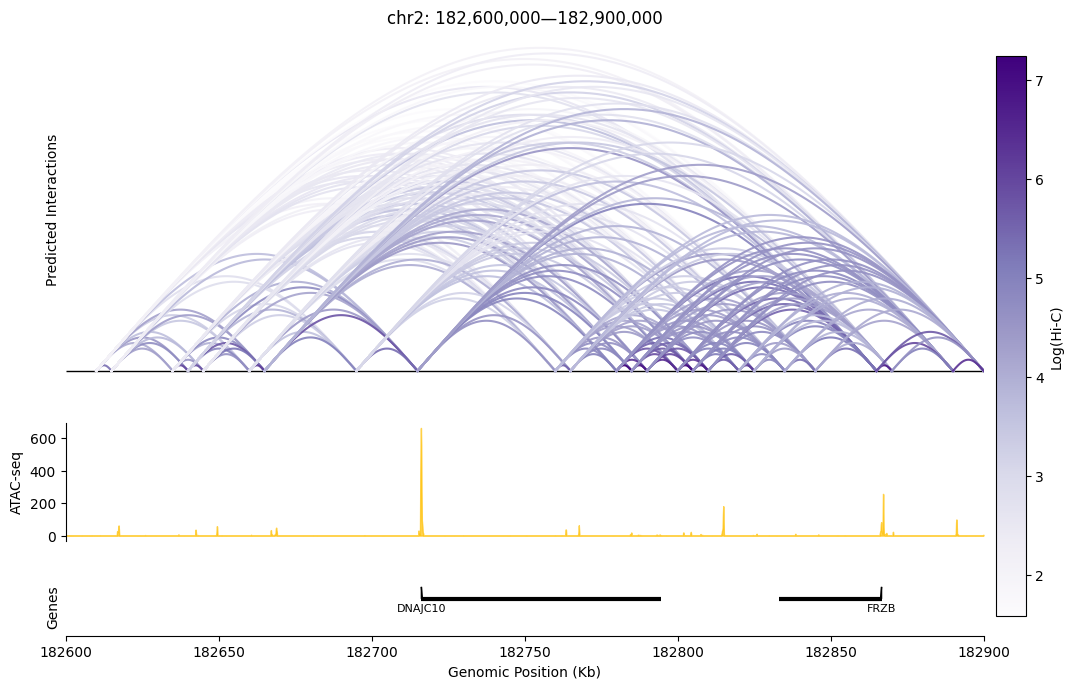

In [13]:
# Plot arcs for a given region
region = "chr2:182600000-182900000"

plot_arcs(region)

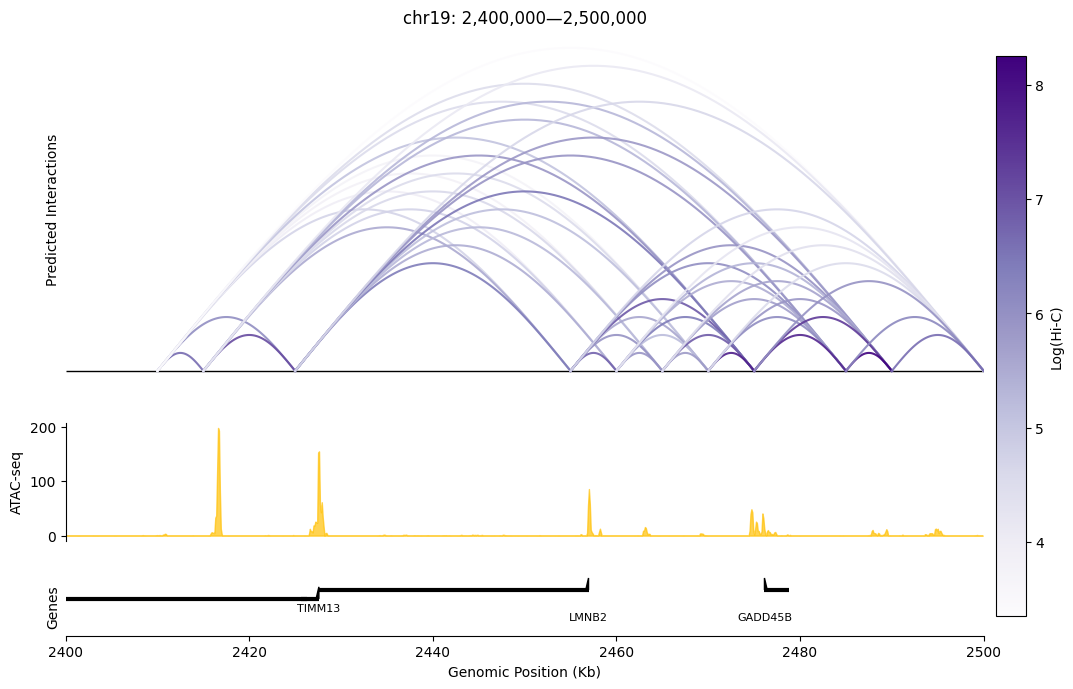

In [14]:
region = "chr19:2400000-2500000"

plot_arcs(region)

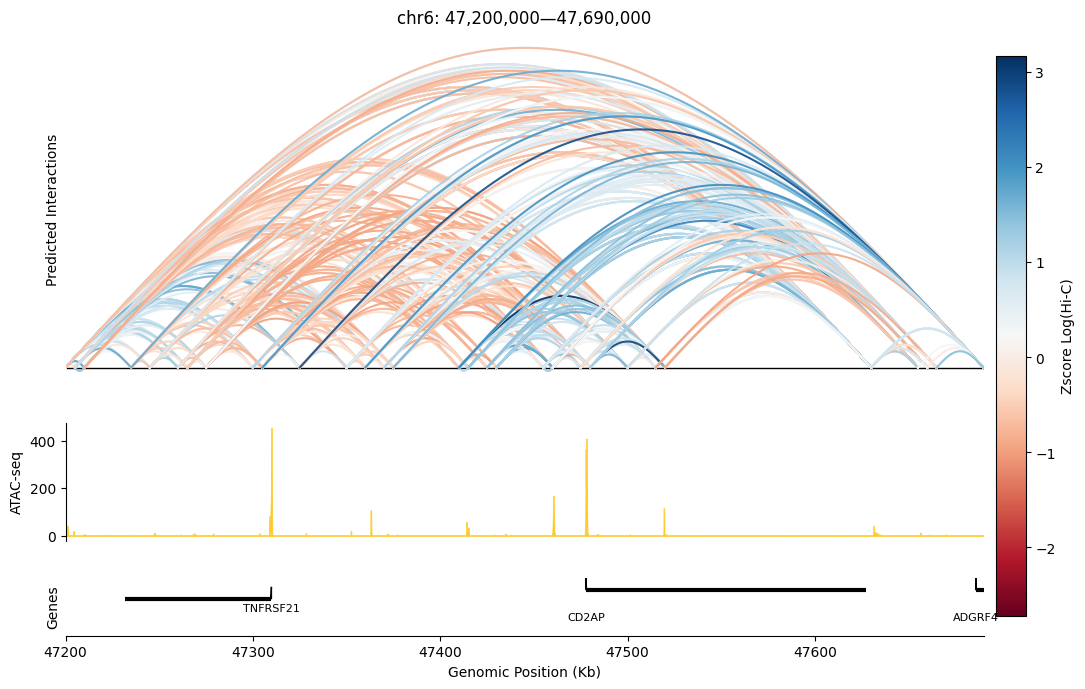

In [15]:
region = "chr6:47200000-47690000"

plot_arcs(region, zscore=True, cutoff=-1)

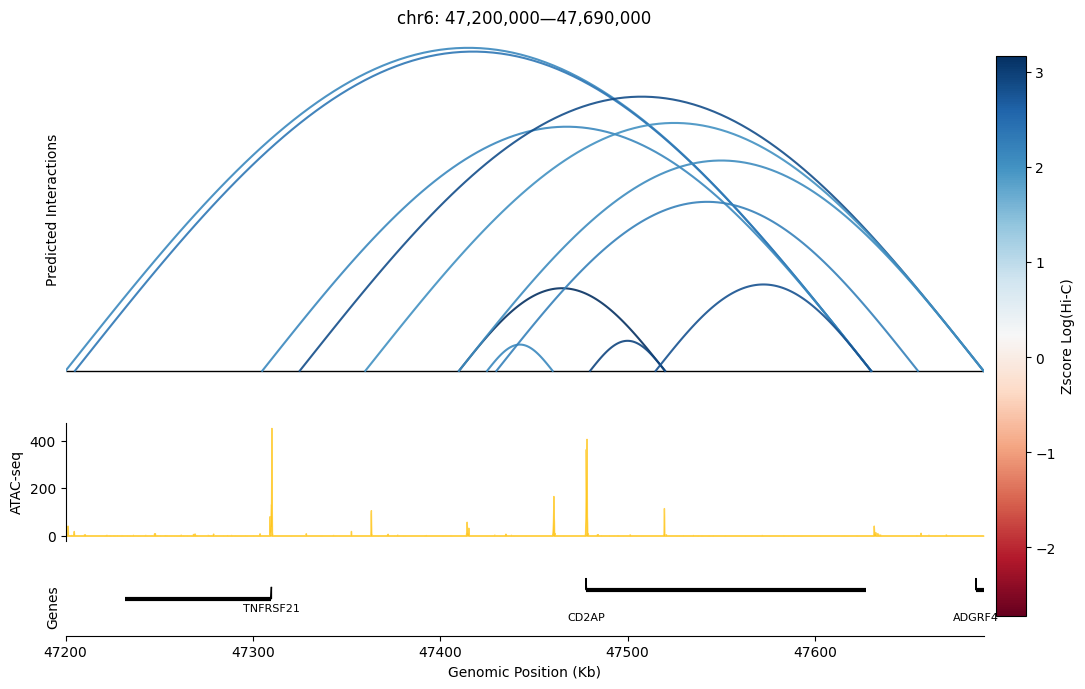

In [16]:
region = "chr6:47200000-47690000"

plot_arcs(region, zscore=True, cutoff=2)